In [1]:
%matplotlib inline
# color-blind friendly colors
red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
gray = '#999999'
yellow = '#dede00'
colors = [red, blue, green, pink, brown, purple, gray, yellow]

In [2]:
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import SubhaloPhaseSpace

logmmin, logmmax = 10.6, 15.2
subocc_model = SubhaloPhaseSpace('satellites', np.logspace(logmmin, logmmax, 15))

baseline_model = PrebuiltHodModelFactory('cacciato09')
model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=subocc_model)

model.populate_mock(CachedHaloCatalog(simname='bolplanck'))

In [4]:
model.mock.populate()

In [5]:
gals = model.mock.galaxy_table

low_mhost, high_mhost = 10**13.9, 10**14.1
mhost_mask = (gals['halo_mvir_host_halo'] > low_mhost) & (gals['halo_mvir_host_halo'] < high_mhost)
sample = gals[mhost_mask]

satmask = sample['gal_type'] == 'satellites'
sats = sample[satmask]
cens = sample[~satmask]

print("Number of satellites = {0}".format(len(sats)))
print("Number of centrals = {0}".format(len(cens)))

Number of satellites = 2307
Number of centrals = 309


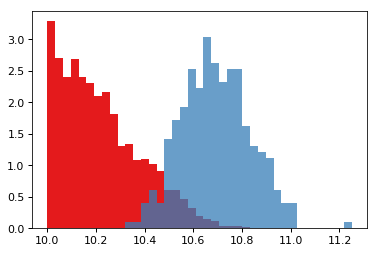

In [6]:
fig, ax = plt.subplots(1, 1)

num_lumbins = 40
__=ax.hist(np.log10(sats['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
          color=red)
__=ax.hist(np.log10(cens['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
           alpha=0.75, color=blue)

In [14]:
from halotools.empirical_models import randomly_resort

idx_sorted_mpeak = np.argsort(sats['halo_mpeak'])
idx_sorted_luminosity = np.argsort(sats['luminosity'])

sats['new_luminosity'] = 0.
sats['new_luminosity'][idx_sorted_mpeak] = sats['luminosity'][idx_sorted_luminosity]
sats['new_luminosity2'] = randomly_resort(sats['new_luminosity'], 0.1)

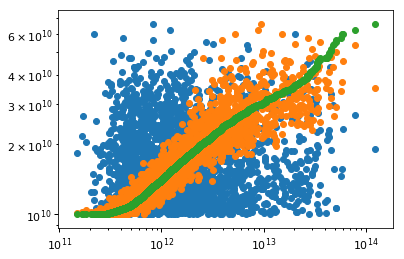

In [16]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.scatter(sats['halo_mpeak'], sats['luminosity'])
__=ax.scatter(sats['halo_mpeak'], sats['new_luminosity2'])
__=ax.scatter(sats['halo_mpeak'], sats['new_luminosity'])